In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import ecg_plot

import tensorflow as tf
from keras import layers
from keras import models
from keras import callbacks
#from keras import optimizers
from tensorflow.keras import optimizers

In [104]:
X = np.load('../Thesis/data/AF_500Hz/ecgeq-500hzsrfava.npy')
Y = pd.read_csv('../Thesis/data/AF_y/coorteeqsrafva.csv',sep=';')

In [105]:
X.shape

(6428, 5000, 12)

In [106]:
Y['ritmi'].value_counts()  # The count is balanced, for now no need to resample

VA    2841
SR    2000
AF    1587
Name: ritmi, dtype: int64

In [107]:
Y

,Unnamed: 0,diagnosi,ecg_id,ritmi,patient_id,age,sex,height,weight,nurse,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,0,STACH,10900,VA,15654.0,54.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
1,1,AFLT,10900,AF,15654.0,54.0,0,NaN,NaN,0.0,...,False,NaN,NaN,NaN,NaN,NaN,NaN,6,records100/10000/10900_lr,records500/10000/10900_hr
2,2,SR,8209,SR,12281.0,55.0,0,NaN,NaN,1.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,10,records100/08000/08209_lr,records500/08000/08209_hr
3,3,STACH,17620,VA,2007.0,29.0,1,164.0,56.0,7.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,1,records100/17000/17620_lr,records500/17000/17620_hr
4,4,SBRAD,12967,VA,8685.0,57.0,0,NaN,NaN,0.0,...,False,NaN,", I-AVR,",NaN,NaN,NaN,NaN,1,records100/12000/12967_lr,records500/12000/12967_hr
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6423,6423,SARRH,4131,VA,3829.0,81.0,0,178.0,70.0,11.0,...,True,NaN,NaN,NaN,NaN,NaN,NaN,4,records100/04000/04131_lr,records500/04000/04131_hr
6424,6424,STACH,18644,VA,3866.0,88.0,0,152.0,45.0,11.0,...,True,"v3,",NaN,NaN,NaN,2ES,NaN,10,records100/18000/18644_lr,records500/18000/18644_hr
6425,6425,SR,3693,SR,17345.0,83.0,1,NaN,NaN,1.0,...,True,NaN,", I-AVR,",NaN,NaN,NaN,NaN,5,records100/03000/03693_lr,records500/03000/03693_hr
6426,6426,AFIB,1039,AF,6038.0,75.0,1,177.0,80.0,NaN,...,True,NaN,NaN,NaN,NaN,2ES,NaN,7,records100/01000/01039_lr,records500/01000/01039_hr


In [127]:
def plot_ecg(rhythm_type, lead_num):
    rhythm_index = Y[Y['ritmi']==rhythm_type].index
    rhythm_data = X[rhythm_index[0], :, :]
    for i in range(lead_num):
        ecg_plot.plot_1(rhythm_data[:, i], title='Plotting for %s, lead %d'%(rhythm_type, i+1))

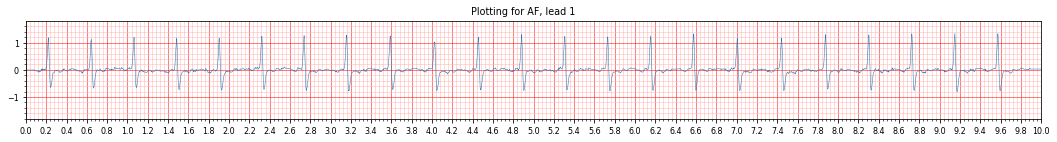

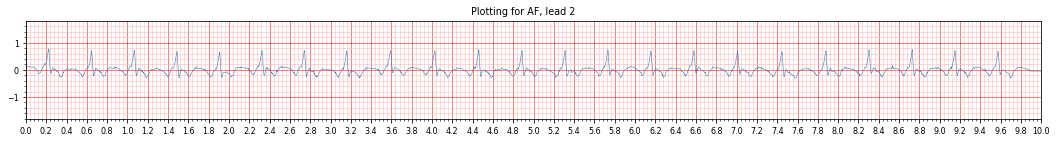

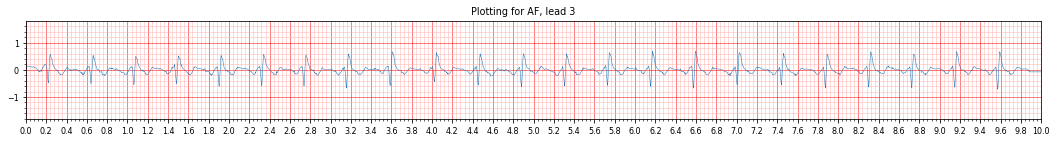

In [129]:
plot_ecg('AF', 3)

In [45]:
# the 'y' I'm going to use for the time being.
# Only use the column 'ritmi'
# AF=1, others = 0, do binary classification

y = np.array(Y['ritmi'])
y = np.where(y=='AF', 1, 0)

In [73]:
# the last 1000 is test set
X_train = X[:5428, :, :]; y_train = y[:5428]
X_test = X[5428:, :, :]; y_test = y[5428:]

In [84]:
X_train = X_train.reshape(5428, 1, 5000, 12)
X_test = X_test.reshape(1000, 1, 5000, 12)

In [85]:
X_test.shape

(1000, 1, 5000, 12)

**Data is ready, start build the model**

In [86]:
model = models.Sequential()

# The first Conv layer
model.add(layers.Conv2D(32, (1,3), activation='relu', input_shape=(1, 5000, 12)))
model.add(layers.MaxPooling2D((1,2)))

# The second Conv layer
model.add(layers.Conv2D(64, (1,3), activation='relu'))
model.add(layers.MaxPooling2D((1,2)))

# The third Conv layer
model.add(layers.Conv2D(128, (1,3), activation='relu'))
model.add(layers.MaxPooling2D((1,2)))

# The fourth Conv layer
model.add(layers.Conv2D(128, (1,3), activation='relu'))
model.add(layers.MaxPooling2D((1,2)))

# At the end of Conv layers, fully-connected layers are needed
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', 
              optimizer=optimizers.RMSprop(learning_rate=1e-4),
              metrics=['accuracy'])

callback = [callbacks.EarlyStopping(monitor='val_loss', patience=8),
             callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)]

In [89]:
history=model.fit(X_train, y_train,epochs=30, batch_size=32,validation_data=(X_test,y_test))

Epoch 1/30
170/170 [==============================] - 4s 21ms/step - loss: 0.0226 - accuracy: 0.9906 - val_loss: 1.3071 - val_accuracy: 0.8190
Epoch 2/30
170/170 [==============================] - 3s 19ms/step - loss: 0.0297 - accuracy: 0.9895 - val_loss: 1.0166 - val_accuracy: 0.8120
Epoch 3/30
170/170 [==============================] - 3s 19ms/step - loss: 0.0285 - accuracy: 0.9886 - val_loss: 1.0873 - val_accuracy: 0.8070
Epoch 4/30
170/170 [==============================] - 3s 19ms/step - loss: 0.0188 - accuracy: 0.9919 - val_loss: 1.3174 - val_accuracy: 0.8120
Epoch 5/30
170/170 [==============================] - 3s 19ms/step - loss: 0.0208 - accuracy: 0.9930 - val_loss: 1.1212 - val_accuracy: 0.8120
Epoch 6/30
170/170 [==============================] - 3s 19ms/step - loss: 0.0339 - accuracy: 0.9888 - val_loss: 0.8956 - val_accuracy: 0.7970
Epoch 7/30
170/170 [==============================] - 3s 19ms/step - loss: 0.0228 - accuracy: 0.9904 - val_loss: 1.4768 - val_accuracy: 0.8050

In [94]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy)+1)

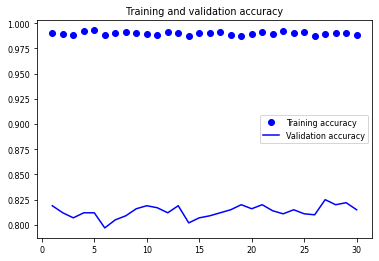

In [99]:
plt.plot(epochs, accuracy, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

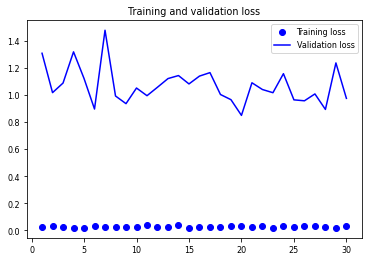

In [100]:
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()